In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/AVA Retail/TrainData.csv")
df

,Unnamed: 0,images,labels,IMAGES
0,0,IMG_1.jpg,annoyed,72 78 81 75 59 54 63 61 55 55 62 46 93 114 121...
1,1,IMG_4.jpg,annoyed,152 149 147 157 146 133 114 138 170 175 184 15...
2,2,IMG_7.jpg,scared,231 214 155 166 171 137 160 174 181 204 102 40...
3,3,IMG_10.jpg,upset,24 32 35 34 30 21 19 20 29 39 20 24 30 36 21 1...
4,4,IMG_13.jpg,content,4 0 0 1 0 0 0 0 1 0 0 0 5 13 22 28 49 49 59 84...
...,...,...,...,...
28816,28816,IMG_107641.jpg,scared,163 173 175 171 172 175 177 182 189 191 196 20...
28817,28817,IMG_107647.jpg,content,51 33 17 23 21 31 34 39 33 37 38 37 38 44 48 4...
28818,28818,IMG_107650.jpg,joyful,179 172 172 173 179 189 193 192 196 199 200 20...
28819,28819,IMG_107656.jpg,joyful,32 27 29 29 31 30 41 69 79 80 78 67 69 69 64 6...


In [5]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [3]:
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [7]:
df['IMAGES'] = df['IMAGES'].apply(lambda x: string2array(x))

In [8]:
df['IMAGES'][2].shape

(48, 48, 1)

In [9]:
df['IMAGES'][2]

array([[[231.],
        [214.],
        [155.],
        ...,
        [ 44.],
        [ 29.],
        [ 16.]],

       [[229.],
        [172.],
        [150.],
        ...,
        [ 26.],
        [ 34.],
        [ 25.]],

       [[214.],
        [156.],
        [155.],
        ...,
        [ 27.],
        [ 21.],
        [ 31.]],

       ...,

       [[239.],
        [246.],
        [251.],
        ...,
        [ 58.],
        [100.],
        [148.]],

       [[245.],
        [250.],
        [252.],
        ...,
        [ 79.],
        [104.],
        [161.]],

       [[250.],
        [251.],
        [250.],
        ...,
        [ 85.],
        [114.],
        [153.]]], dtype=float32)

In [10]:
# df.labels.unique()
label_to_text = {0:'annoyed', 1:'scared', 2:'upset', 3:'content', 4: 'joyful', 5: 'shocked', 6:'irritated'}

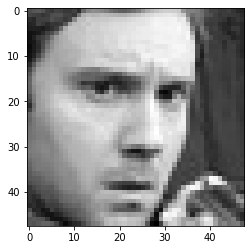

In [11]:
plt.imshow(df['IMAGES'][0].squeeze(),cmap='gray')

In [12]:
emotions = [0,1,2,3,4,5,6]

# for i in emotions:
#   data = df[df['labels'] == i][:1]
#   img = data['IMAGES'].item()
#   img = img.reshape(48,48)
#   plt.figure()
#   plt.title(label_to_text[i])
#   plt.imshow(img, cmap= 'gray')


# for i in emotions:
#   data = df[df['labels'] == i][:1]
#   img = data['IMAGES'].item()
#   img = img.reshape(48,48)
#   plt.figure()
#   plt.title(label_to_text[i])
#   plt.imshow(img, cmap= 'gray')

Text(0.5, 1.0, 'Number of images per emotion')

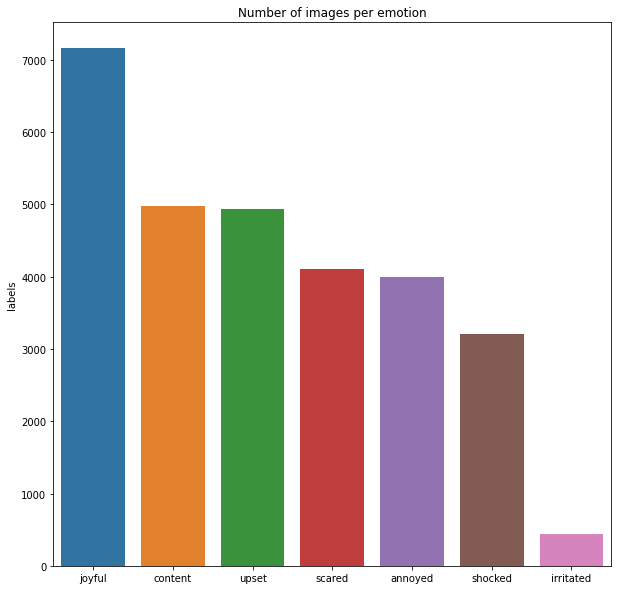

In [13]:
plt.figure(figsize=(10,10))
sns.barplot(x=df.labels.value_counts().index,y=df.labels.value_counts())
plt.title('Number of images per emotion')

In [14]:
X = df['IMAGES']
X.shape

(28821,)

In [15]:
# Splitting The Dataframe To Features And Labels
X = df['IMAGES']
y = pd.get_dummies(df['labels'])

X = np.stack(X, axis = 0)
X = X.reshape(28821, 48, 48, 1)

print(X.shape, y.shape)

(28821, 48, 48, 1) (28821, 7)


In [16]:
X.shape

(28821, 48, 48, 1)

In [17]:
y.shape

(28821, 7)

In [18]:
X = np.array(X)
y = np.array(y)

In [19]:
# Spliting The Dataframe In To Train, And Validation Data Frames

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, shuffle = True)

In [20]:
# Image Pre-processing

X_train = X_train/255
X_val   = X_val /255

In [21]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode = "nearest"
)

In [22]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode = "nearest", 
    vertical_flip=True,
)

In [23]:
def res_block(X, filter, stage):

  X_copy = X

  f1 , f2, f3 = filter

  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  X_copy = X


  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  X_copy = X

  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [32]:
input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

X = ZeroPadding2D((3, 3))(X_input)

X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

X = res_block(X, filter= [64, 64, 256], stage= 2)

X = res_block(X, filter= [128, 128, 512], stage= 3)

X = AveragePooling2D((2, 2), name = 'Averagea_Pooling')(X)

X = Flatten()(X)
X = Dense(7, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X, name = 'Custom-Resnet')

model_emotion.summary()

Model: "Custom-Resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']      

In [33]:
# Training The Network
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [34]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "Ashish_Facial_Exp.hdf5", verbose = 1, save_best_only=True)

In [35]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
  epochs= 100, callbacks=[checkpointer, earlystopping])

Epoch 1/100
360/360 [==============================] - ETA: 0s - loss: 1.8886 - accuracy: 0.2467
Epoch 00001: val_loss improved from inf to 1.95526, saving model to Ashish_Facial_Exp.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


360/360 [==============================] - 24s 58ms/step - loss: 1.8886 - accuracy: 0.2467 - val_loss: 1.9553 - val_accuracy: 0.1738
Epoch 2/100
360/360 [==============================] - ETA: 0s - loss: 1.7314 - accuracy: 0.3070
Epoch 00002: val_loss improved from 1.95526 to 1.89017, saving model to Ashish_Facial_Exp.hdf5
360/360 [==============================] - 20s 55ms/step - loss: 1.7314 - accuracy: 0.3070 - val_loss: 1.8902 - val_accuracy: 0.2933
Epoch 3/100
360/360 [==============================] - ETA: 0s - loss: 1.6504 - accuracy: 0.3498
Epoch 00003: val_loss improved from 1.89017 to 1.87962, saving model to Ashish_Facial_Exp.hdf5
360/360 [==============================] - 19s 54ms/step - loss: 1.6504 - accuracy: 0.3498 - val_loss: 1.8796 - val_accuracy: 0.2871
Epoch 4/100
359/360 [============================>.] - ETA: 0s - loss: 1.5855 - accuracy: 0.3785
Epoch 00004: val_loss did not improve from 1.87962
360/360 [==============================] - 19s 52ms/step - loss: 1.58

In [36]:
# Saving the model architecture to json file for future use

model_json = model_emotion.to_json()
with open("Ashish_Facial_Exp.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

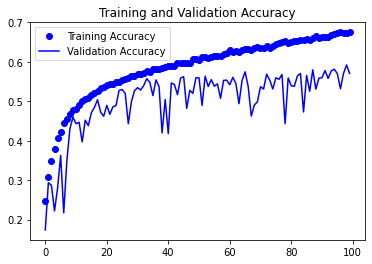

In [39]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

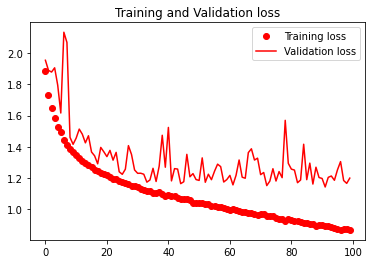

In [40]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [42]:
model_emotion.save('/content/drive/MyDrive/AVA Retail/Ashish_Facial_Exp.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [4]:
from tensorflow.keras.models import load_model
new_model = load_model('/content/drive/MyDrive/AVA Retail/Ashish_Facial_Exp.h5')
new_model.summary()

Model: "Custom-Resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']      

In [5]:
df2 = pd.read_csv("/content/drive/MyDrive/AVA Retail/TestData.csv")
df2 = df2.drop(['Unnamed: 0'], axis = 1)
df2['IMAGES'] = df2['IMAGES'].apply(lambda x: string2array(x))
df2

,images,labels,IMAGES
0,IMG_25.jpg,NaN,"[[[86.0], [83.0], [91.0], [120.0], [100.0], [1..."
1,IMG_61.jpg,NaN,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1..."
2,IMG_64.jpg,NaN,"[[[176.0], [49.0], [36.0], [39.0], [38.0], [42..."
3,IMG_70.jpg,NaN,"[[[7.0], [9.0], [16.0], [20.0], [25.0], [33.0]..."
4,IMG_91.jpg,NaN,"[[[233.0], [232.0], [227.0], [235.0], [233.0],..."
...,...,...,...
7061,IMG_107608.jpg,NaN,"[[[216.0], [220.0], [222.0], [223.0], [224.0],..."
7062,IMG_107617.jpg,NaN,"[[[132.0], [162.0], [89.0], [58.0], [9.0], [0...."
7063,IMG_107620.jpg,NaN,"[[[54.0], [57.0], [75.0], [124.0], [121.0], [7..."
7064,IMG_107644.jpg,NaN,"[[[180.0], [177.0], [176.0], [157.0], [180.0],..."


In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [25]:
def classify(img):
  Labels = ['annoyed','scared','upset','content','joyful','shocked','irritated']
  img2 = img/255
  img_array = img2.reshape(1,48,48)
  # img_batch = np.expand_dims(img_array, axis=0)
  # img_preprocessed = preprocess_input(img_batch)
  # print(img_preprocessed.shape)
  # print(img_preprocessed)
  model = new_model
  prediction = model.predict(img_array)
  cls = np.argmax(prediction[0])
  return Labels[cls]


In [26]:
arr = []
for i in range(len(df2["IMAGES"])):
  ans = classify((df2["IMAGES"][i]))
  arr.append(ans)


In [28]:
result = [classify(x) for x in df2['IMAGES']]

In [36]:
df2 = df2.drop(['labels'], axis = 1)

In [37]:
df2

,images,IMAGES
0,IMG_25.jpg,"[[[86.0], [83.0], [91.0], [120.0], [100.0], [1..."
1,IMG_61.jpg,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1..."
2,IMG_64.jpg,"[[[176.0], [49.0], [36.0], [39.0], [38.0], [42..."
3,IMG_70.jpg,"[[[7.0], [9.0], [16.0], [20.0], [25.0], [33.0]..."
4,IMG_91.jpg,"[[[233.0], [232.0], [227.0], [235.0], [233.0],..."
...,...,...
7061,IMG_107608.jpg,"[[[216.0], [220.0], [222.0], [223.0], [224.0],..."
7062,IMG_107617.jpg,"[[[132.0], [162.0], [89.0], [58.0], [9.0], [0...."
7063,IMG_107620.jpg,"[[[54.0], [57.0], [75.0], [124.0], [121.0], [7..."
7064,IMG_107644.jpg,"[[[180.0], [177.0], [176.0], [157.0], [180.0],..."


In [45]:
df3 = df2.copy()

In [47]:
df3 = df3.drop(['IMAGES'], axis = 1)

In [50]:
df3['labels'] = arr

In [52]:
df3.rename(columns = {'images':'image id'}, inplace = True)

In [56]:
df3.to_csv('Test_results.csv',index=False)

In [55]:
df3

,image id,labels
0,IMG_25.jpg,content
1,IMG_61.jpg,scared
2,IMG_64.jpg,joyful
3,IMG_70.jpg,joyful
4,IMG_91.jpg,content
...,...,...
7061,IMG_107608.jpg,content
7062,IMG_107617.jpg,scared
7063,IMG_107620.jpg,irritated
7064,IMG_107644.jpg,annoyed
